In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import kalepy as kale

In [4]:
import trove
import verdict

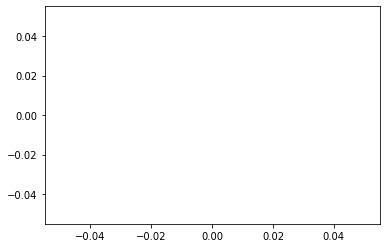

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# # Currently need to call this to get matplotlib selected style to load...
plt.plot()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold-mnras.mplstyle' )
import palettable
import matplotlib.patheffects as path_effects

In [6]:
import helpers

# Parameters

In [7]:
summary_data_fp = './data/polished_data/summary.h5'
figure_dir = '/Users/zhafen/drafts/cgm_modeling_challenge_paper/figures'

In [8]:
pm = {
    'jitter_width': 0.3,
    'percentiles': 0.68,
}

In [9]:
rng = np.random.default_rng()

In [10]:
mosaic = [ [ 'Z', ], [ 'T', ], [ 'nH', ], ]
lims = {
    'T': [ 4, 6 ],
    'nH': [ -5.5, 0 ],
    'Z': [ -2.5, 2 ],
}

In [11]:
fraction = pm['percentiles']
onesided_fraction = ( 1 - fraction ) / 2.
percentile_str = helpers.percentile_str_fn( fraction )
lower_percentile_str = helpers.percentile_str_fn( onesided_fraction )
upper_percentile_str = helpers.percentile_str_fn( 1. - onesided_fraction )

# Load Data

In [12]:
summary = verdict.Dict.from_hdf5( summary_data_fp, create_nonexistent=True )

/Users/zhafen/repos/verdict/verdict.py:1523: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


# Averages

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )


Saved at /Users/zhafen/drafts/cgm_modeling_challenge_paper/figures/averages.0.pdf


/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:204: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )


Saved at /Users/zhafen/drafts/cgm_modeling_challenge_paper/figures/averages.1.pdf


/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_2383/85982100.py:204: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )
/Users/zhafen/miniconda3/envs/cgm_modeling_challenge/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


Saved at /Users/zhafen/drafts/cgm_modeling_challenge_paper/figures/averages.pdf


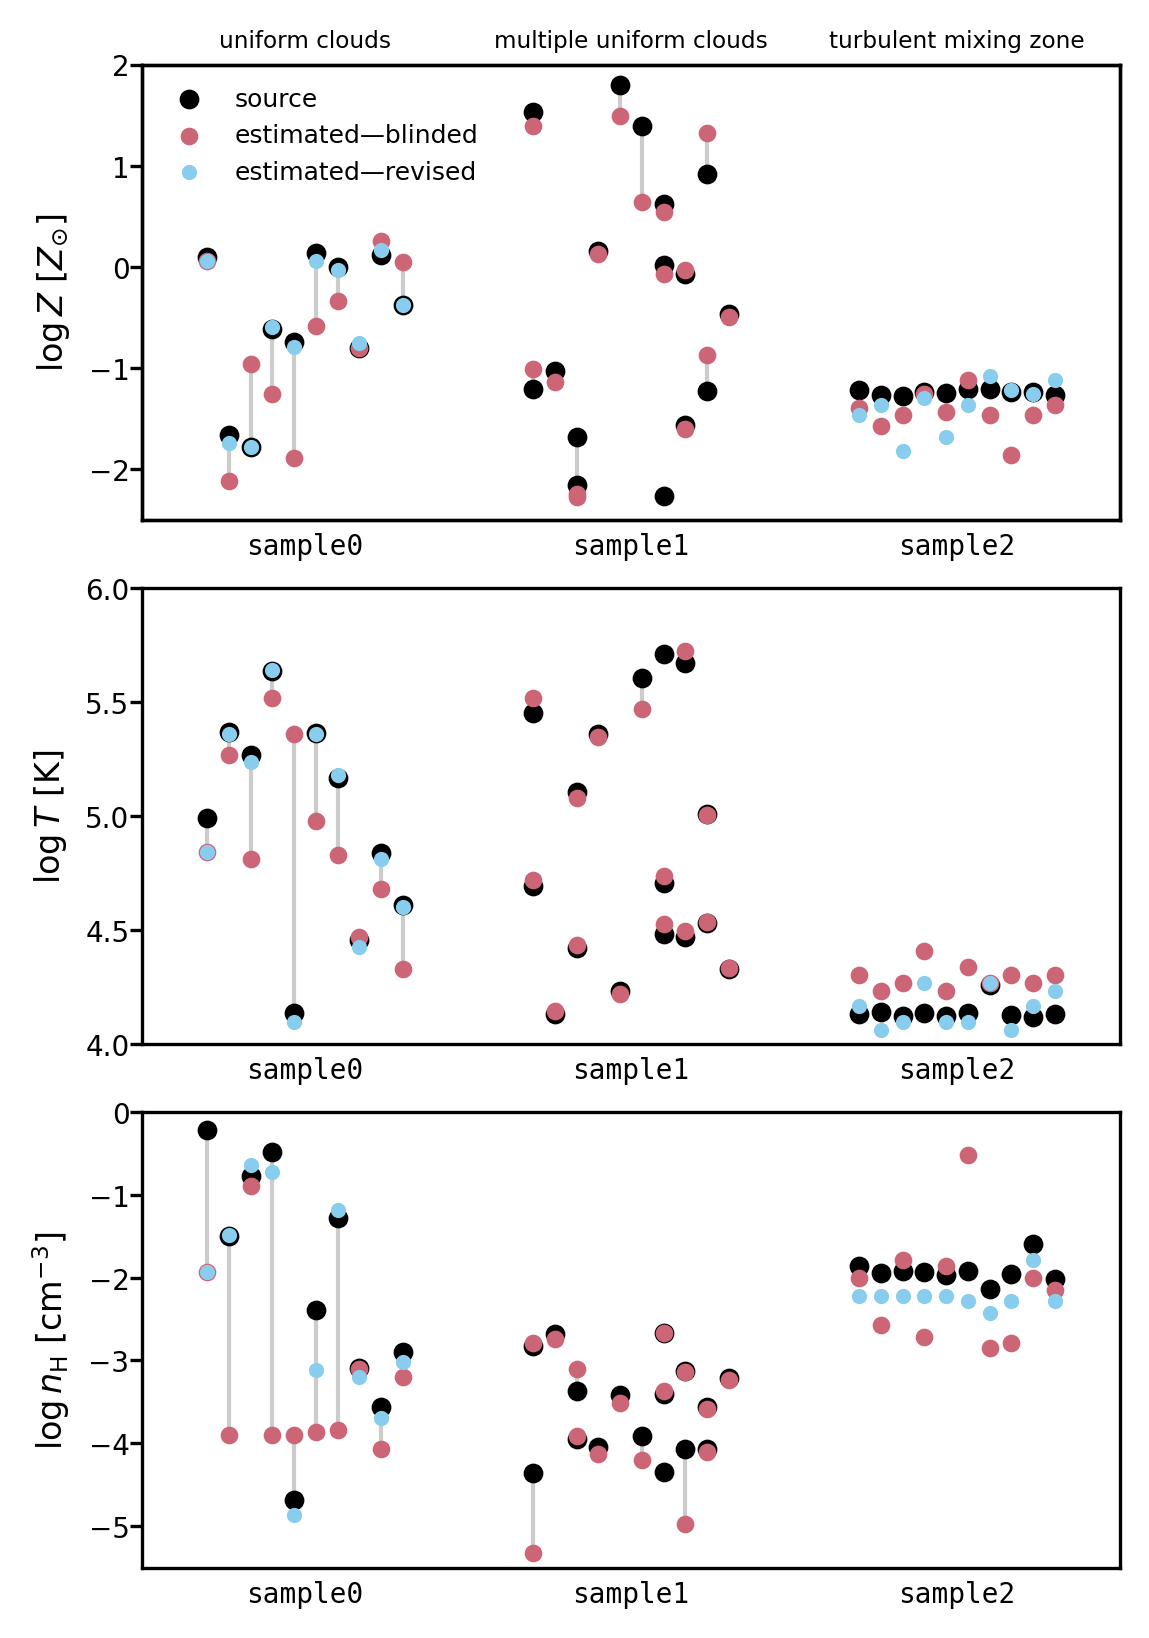

In [14]:
n_rows = len( mosaic )
n_cols = len( mosaic[0] )
panel_width = matplotlib.rcParams['figure.figsize'][0]
fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width/2.), facecolor='w' )

main_ax = plt.gca()
main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
for spine in main_ax.spines.values():
    spine.set_visible( False )

ax_dict = fig.subplot_mosaic(
    mosaic,
    gridspec_kw = { 'hspace': 0.15, },
)

# General changes
for ax_key, ax in ax_dict.items():
    # ylim = helpers.lims[ax_key]
    # if helpers.logscale[ax_key]:
    #     ylim = np.log10( ylim )
    
    ax.set_xlim( -0.5, 2.5 )
    ax.set_ylim( lims[ax_key] )
    
    ax.set_xticks( [ 0, 1, 2 ] )
    ax.set_xticklabels( [ 'sample0', 'sample1', 'sample2' ], fontname='monospace' )
    
    if ax_key == 'T':
        ax.set_yticks( np.arange( lims['T'][0], lims['T'][1] + 0.5, 0.5 ) )
    
    if ax.get_subplotspec().is_first_row():
        top_ax = ax.twiny()
        top_ax.set_xlim( ax.get_xlim() )
        top_ax.set_xticks( [ 0, 1, 2 ] )
        top_ax.set_xticklabels( [ 'uniform clouds', 'multiple uniform clouds', 'turbulent mixing zone' ], fontsize='x-small' )
        top_ax.tick_params( top=False, pad=0 )
    
    ax.tick_params( bottom=False, pad=0 )
    
    ax.set_ylabel( helpers.property_labels[ax_key] )
    
xs_set = False
for k, (ax_key, ax) in enumerate( ax_dict.items() ):
    
    ########################################################
    # sample0
    ########################################################
    
    # Plot sample0 averages
    ys = summary['sample0']['source'][ax_key]
    if not xs_set:
        # xs = rng.normal( 0, pm['jitter_width'], ys.size )
        xs = np.linspace( -pm['jitter_width'], pm['jitter_width'], ys.size )
        xs_set = True
    s = ax.scatter(
        xs,
        ys,
        s = plt.rcParams['lines.markersize'] * 2,
        color = 'k',
        label = 'source',
    )
    
    # Plot sample0 blinded averages
    ys = summary['sample0']['estimated']['blinded']['mle'][ax_key]
    s = ax.scatter(
        xs,
        ys,
        s = plt.rcParams['lines.markersize'] * 1.5,
        color = helpers.blinded_color,
        label = 'estimated\u2014blinded',
    )
    
    # Plot sample0 revised averages
    ys = summary['sample0']['estimated']['revised']['mle'][ax_key]
    s = ax.scatter(
        xs,
        ys,
        s = plt.rcParams['lines.markersize'],
        color = helpers.revised_color,
        label = 'estimated\u2014revised',
    )
    
    # Draw connecting lines
    for i, x in enumerate( xs ):
        ys = np.array([
            summary['sample0']['source'][ax_key][i],
            summary['sample0']['estimated']['blinded']['mle'][ax_key][i],
            summary['sample0']['estimated']['revised']['mle'][ax_key][i],
        ])
        ax.plot(
            [ x, x ],
            [ ys.min(), ys.max() ],
            color = '0.8',
            zorder = -10,
            linewidth = 1,
        )
        
    if ax.get_subplotspec().is_first_row():
        ax.legend(
            loc = 'upper left',
            prop = { 'size': 6, },
            edgecolor = 'none',
        )
        
    if k == len( ax_dict ) - 1:
        save_fp = os.path.join( figure_dir, 'averages.0.pdf' )
        plt.savefig( save_fp, bbox_inches='tight' )
        print( 'Saved at ' + save_fp )
        
    ########################################################
    # sample1
    ########################################################
    
    xs1 = xs + 1.
    
    # Actual values
    ys_dict = summary['sample1']['source'][ax_key]
    ys_actual = []
    xs_for_clouds = []
    for j, sl in enumerate( ys_dict.keys_array() ):
        ys_sl = ys_dict[sl]
        ys_actual.append( ys_sl )
        xs_for_clouds += [ xs1[j], ] * len(ys_sl )
    ax.scatter(
        np.array( xs_for_clouds ),
        np.concatenate( ys_actual ),
        s = plt.rcParams['lines.markersize'] * 2,
        color = 'k',
    )
    
    # Estimates
    ys_dict = summary['sample1']['estimated']['maximum likelihood estimate'][ax_key]
    ys_estimated = []
    xs_for_clouds = []
    for j, sl in enumerate( ys_dict.keys_array() ):
        ys_sl = ys_dict[sl].array()
        ys_estimated.append( ys_sl )
        xs_for_clouds += [ xs1[j], ] * len( ys_sl )
    ax.scatter(
        np.array( xs_for_clouds ),
        np.concatenate( ys_estimated ),
        s = plt.rcParams['lines.markersize'] * 1.5,
        color = helpers.blinded_color,
    )
    
    # Draw connecting lines
    for i, x in enumerate( xs1 ):
        
        # Throw out the one exception that's already discussed in the text.
        # The really hot, low-metallicity component in sightline 50
        if i == 6:
            ys_actual[i] = np.array([ ys_actual[i][0], ys_actual[i][2] ])
        
        # Find closest matches
        diff_arr = np.abs( ys_actual[i][:,np.newaxis] - ys_estimated[i] )
        inds_matched = np.argmin( diff_arr, axis=1 )

        for j, y_actual in enumerate( ys_actual[i] ):
            ax.plot(
                [ x, x ],
                [ y_actual, ys_estimated[i][inds_matched[j]] ],
                color = '0.8',
                zorder = -10,
                linewidth = 1,
            )
            
    if k == len( ax_dict ) - 1:
        save_fp = os.path.join( figure_dir, 'averages.1.pdf' )
        plt.savefig( save_fp, bbox_inches='tight' )
        print( 'Saved at ' + save_fp )
            
    ########################################################
    # sample2
    ########################################################
    
    xs2 = xs + 2.
    
    # Source data
    ys = summary['sample2']['averages']['blinded']['source'][ax_key].array()
    s = ax.scatter(
        xs2,
        ys,
        s = plt.rcParams['lines.markersize'] * 2,
        color = 'k',
    )
    
    ys = summary['sample2']['averages']['blinded']['estimated']['MLE'][ax_key].array()
    s = ax.scatter(
        xs2,
        ys,
        s = plt.rcParams['lines.markersize'] * 1.5,
        color = helpers.blinded_color,
    )
    
    ys = summary['sample2']['averages']['revised']['estimated']['MLE'][ax_key].array()
    s = ax.scatter(
        xs2,
        ys,
        s = plt.rcParams['lines.markersize'],
        color = helpers.revised_color,
    )
    
save_fp = os.path.join( figure_dir, 'averages.pdf' )
plt.savefig( save_fp, bbox_inches='tight' )
print( 'Saved at ' + save_fp )

# Posterior Widths

In [ ]:
summary['sample0']['estimated']['revised']['error']

In [ ]:
n_rows = len( mosaic )
n_cols = len( mosaic[0] )
panel_width = matplotlib.rcParams['figure.figsize'][0]
fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width/2.), facecolor='w' )

main_ax = plt.gca()
main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
for spine in main_ax.spines.values():
    spine.set_visible( False )

ax_dict = fig.subplot_mosaic(
    mosaic,
    gridspec_kw = { 'hspace': 0.15, },
)

# General changes
for ax_key, ax in ax_dict.items():
    # ylim = helpers.lims[ax_key]
    # if helpers.logscale[ax_key]:
    #     ylim = np.log10( ylim )
    
    ax.set_xlim( -0.5, 2.5 )
    # ax.set_ylim( lims[ax_key] )
    
    ax.set_xticks( [ 0, 1, 2 ] )
    ax.set_xticklabels( [ 'sample0', 'sample1', 'sample2' ], fontname='monospace' )
    
    if ax.get_subplotspec().is_first_row():
        top_ax = ax.twiny()
        top_ax.set_xlim( ax.get_xlim() )
        top_ax.set_xticks( [ 0, 1, 2 ] )
        top_ax.set_xticklabels( [ 'uniform clouds', 'multiple uniform clouds', 'turbulent mixing zone' ], fontsize='x-small' )
        top_ax.tick_params( top=False, pad=0 )
    
    ax.tick_params( bottom=False, pad=0 )
    
    ax.set_ylabel( helpers.property_labels[ax_key] )
    
    if ax_key == 'T':
        ax.annotate(
            text = '{}th-{}th percentiles'.format( lower_percentile_str[:-2], upper_percentile_str[:-2] ),
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -5, -5 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 'small',
        )
    
xs_set = False
for i, (ax_key, ax) in enumerate( ax_dict.items() ):
    
    ########################################################
    # sample0
    ########################################################
    
    # Plot sample0 source data
    ys = summary['sample0']['source'][ax_key]
    if not xs_set:
        # xs = rng.normal( 0, pm['jitter_width'], ys.size )
        xs = np.linspace( -pm['jitter_width'], pm['jitter_width'], ys.size )
        xs_set = True
    s = ax.scatter(
        xs,
        ys,
        s = plt.rcParams['lines.markersize'] * 2,
        color = 'k',
        label = 'source',
    )
    
    all_ys = [ ys, ]
    
    # Plot sample0 blinded errors
    if ax_key in summary['sample0']['estimated']['blinded']['error']['original provided']:           
        err = summary['sample0']['estimated']['blinded']['error']['original provided'][ax_key]
        ys = summary['sample0']['estimated']['blinded']['mle'][ax_key]
        err_low = ys - err / 2.
        err_high = ys + err / 2.
        
        all_ys.append( ys )
        
        for i, x in enumerate( xs ):
            
            if i == 0:
                label = 'estimated\u2014blinded'
            else:
                label = None
            
            s = ax.plot(
                [ x, x ],
                [ err_low[i], err_high[i] ],
                color = helpers.blinded_color,
                label = label,
                linewidth = 3,
                zorder = -5,
                solid_capstyle = 'round',
            )
            
            
    # Plot sample0 revised errors
    if ax_key in summary['sample0']['estimated']['revised']['error']['1 sigma low']:               
        err_mag_low = summary['sample0']['estimated']['revised']['error']['1 sigma low'][ax_key]
        err_mag_high = summary['sample0']['estimated']['revised']['error']['1 sigma high'][ax_key]
        ys = summary['sample0']['estimated']['revised']['mle'][ax_key]
        err_low = ys - err_mag_low
        err_high = ys + err_mag_high
        
        all_ys.append( ys )

        for i, x in enumerate( xs ):
            
            if i == 0:
                label = 'estimated\u2014revised'
            else:
                label = None
            
            s = ax.plot(
                [ x, x ],
                [ err_low[i], err_high[i] ],
                color = helpers.revised_color,
                label = label,
                linewidth = 2,
                solid_capstyle = 'round',
            )
    
    # Draw connecting lines (but only if we have multiple points)
    if len( all_ys ) > 1:
        all_ys = np.array( all_ys )
        for i, x in enumerate( xs ):
            ax.plot(
                [ x, x ],
                [ all_ys[:,i].min(), all_ys[:,i].max() ],
                color = '0.8',
                zorder = -10,
                linewidth = 1,
            )
        
    if ax.get_subplotspec().is_first_row():
        ax.legend(
            loc = 'upper left',
            prop = { 'size': 6, },
            edgecolor = 'none',
        )
        
    if i == len( ax_dict ) - 1:
        save_fp = os.path.join( figure_dir, 'percentiles.0.pdf' )
        plt.savefig( save_fp, bbox_inches='tight' )
        print( 'Saved at ' + save_fp )
        
        
    ########################################################
    # sample1
    ########################################################
    
    xs1 = xs + 1.
    
    # Actual values
    ys_dict = summary['sample1']['source'][ax_key]
    ys_actual = []
    xs_for_clouds = []
    for j, sl in enumerate( ys_dict.keys_array() ):
        ys_sl = ys_dict[sl]
        ys_actual.append( ys_sl )
        xs_for_clouds += [ xs1[j], ] * len(ys_sl )
    ax.scatter(
        np.array( xs_for_clouds ),
        np.concatenate( ys_actual ),
        s = plt.rcParams['lines.markersize'] * 2,
        color = 'k',
    )
    
    # Plot sample0 blinded errors
    if ax_key in summary['sample1']['estimated']['posterior percentiles']:   
        
        ps = summary['sample1']['estimated']['posterior percentiles'][ax_key]
        for i, ( sl, ps_i ) in enumerate( ps.items() ):
            
            x = xs1[i]
            
            ys_estimated_i = []
            for comp_key, ps_comp in ps_i.items():
                
                s = ax.plot(
                    [ x, x ],
                    [ ps_comp[lower_percentile_str], ps_comp[upper_percentile_str] ],
                    color = helpers.blinded_color,
                    linewidth = 3,
                    zorder = -5,
                    solid_capstyle = 'round',
                )
                
                y = summary['sample1']['estimated']['maximum likelihood estimate'][ax_key][sl][comp_key]
                ys_estimated_i.append( y )
            
            # Find closest matches
            diff_arr = np.abs( ys_actual[i][:,np.newaxis] - ys_estimated_i )
            inds_matched = np.argmin( diff_arr, axis=1 )
            
            # Plot connection between closest matches
            for j, ind_matched in enumerate( inds_matched ):
                ax.plot(
                    [ x, x ],
                    [ ys_actual[i][j], ys_estimated_i[ind_matched] ],
                    color = '0.8',
                    zorder = -10,
                    linewidth = 1,
                )
            
    ########################################################
    # sample2
    ########################################################
    
    xs2 = xs + 2.
    
    for i, x2 in enumerate( xs2 ):
        # Source data
        p_low = summary['sample2']['percentiles']['blinded']['source'][ax_key]['percentile'][lower_percentile_str].array()[i]
        p_high = summary['sample2']['percentiles']['blinded']['source'][ax_key]['percentile'][upper_percentile_str].array()[i]
        ax.plot(
            [ x2, x2 ],
            [ p_low, p_high ],
            color = 'k',
            linewidth = 4,
            solid_capstyle = 'round',
        )

        p_low = summary['sample2']['percentiles']['blinded']['estimated']['combined'][ax_key]['percentile'][lower_percentile_str].array()[i]
        p_high = summary['sample2']['percentiles']['blinded']['estimated']['combined'][ax_key]['percentile'][upper_percentile_str].array()[i]
        ax.plot(
            [ x2, x2 ],
            [ p_low, p_high ],
            color = helpers.blinded_color,
            linewidth = 3,
            zorder = -5,
            solid_capstyle = 'round',
        )

        p_low = summary['sample2']['percentiles']['revised']['estimated']['combined'][ax_key]['percentile'][lower_percentile_str].array()[i]
        p_high = summary['sample2']['percentiles']['revised']['estimated']['combined'][ax_key]['percentile'][upper_percentile_str].array()[i]
        ax.plot(
            [ x2, x2 ],
            [ p_low, p_high ],
            color = helpers.revised_color,
            linewidth = 2,
            solid_capstyle = 'round',
        )
    
save_fp = os.path.join( figure_dir, 'percentiles.pdf' )
plt.savefig( save_fp, bbox_inches='tight' )
print( 'Saved at ' + save_fp )